In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from pipeline.acquisition import load_sisfall_data
from pipeline.preprocessing import change_activity_duration
from pipeline.preprocessing import change_activity_sampling
from pipeline.feature_extraction import extract_features
import joblib
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression



In [2]:
dataset_folder = "datasets/SisFall_dataset/"
models_output_folder = 'models/'
uma_dataset_folder = "datasets/output_uma"

INCLUDE_GYROSCOPE = False

if INCLUDE_GYROSCOPE:
    sensors =  [0, 1, 2, 3, 4, 5]
else:
    sensors = [0, 1, 2]

ignored_subjects = []
duration = 9000
frequency = 200
should_load_sisfall_data = False
should_save_models = True

combined_dataset_folder = "datasets/combined_dataset"

In [3]:

def plot_sensor_data(data):
    # Create a comprehensive plot showing all sensor readings
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))

    # Plot accelerometer data
    axes[0].plot(data.index, data['acc_x'], label='X-axis', color='red', linewidth=1)
    axes[0].plot(data.index, data['acc_y'], label='Y-axis', color='green', linewidth=1)
    axes[0].plot(data.index, data['acc_z'], label='Z-axis', color='blue', linewidth=1)
    axes[0].set_title('Accelerometer Data', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Acceleration (g)', fontsize=12)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot gyroscope data
    if INCLUDE_GYROSCOPE:
        axes[1].plot(data.index, data['gyro_x'], label='X-axis', color='red', linewidth=1)
        axes[1].plot(data.index, data['gyro_y'], label='Y-axis', color='green', linewidth=1)
        axes[1].plot(data.index, data['gyro_z'], label='Z-axis', color='blue', linewidth=1)
        axes[1].set_title('Gyroscope Data ', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Time', fontsize=12)
        axes[1].set_ylabel('Angular Velocity (deg/s)', fontsize=12)
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

    # Adjust layout and show
    plt.tight_layout()
    plt.show()

    # Print some basic statistics
    print("Data Summary:")
    print(f"Duration: {len(data)} samples")
    print(f"Sampling period: ~{(data.index[1] - data.index[0]).total_seconds():.3f} seconds")
    print(f"Total duration: ~{(data.index[-1] - data.index[0]).total_seconds():.1f} seconds")

    print("\nAccelerometer Statistics:")
    print(data[['acc_x', 'acc_y', 'acc_z']].describe())

    if INCLUDE_GYROSCOPE:
        print("\nGyroscope Statistics:")
        print(data[['gyro_x', 'gyro_y', 'gyro_z']].describe())




In [4]:
if should_load_sisfall_data is True:
    raw_dataset = load_sisfall_data(dataset_folder, ignored_subjects, sensors)

    raw_dataset.to_pickle(f"{combined_dataset_folder}/sisfall_raw_dataset.pkl")
else:
    raw_dataset = pd.read_pickle(f"{combined_dataset_folder}/sisfall_raw_dataset.pkl")

In [5]:
ACTIVITY_CLASSES = {
    'walking': ['D01', 'D02'],  
    'jogging': ['D03', 'D04'],
    'fall': ['F01', 'F02', 'F03', 'F04', 'F05', 'F06', 'F07', 'F08', 'F09', 'F10', "F11","F12","F13", "F14","F15"],
    'lying': ['D14'],
    'sitting': ['D11',"D12", "D13"],
    "jumping": ['D19']
}

# Create code to class mapping
CODE_TO_CLASS = {}
for class_name, codes in ACTIVITY_CLASSES.items():
    for code in codes:
        CODE_TO_CLASS[code] = class_name

print("Activity classes defined:")
for class_name, codes in ACTIVITY_CLASSES.items():
    print(f"  {class_name}: {codes}")

Activity classes defined:
  walking: ['D01', 'D02']
  jogging: ['D03', 'D04']
  fall: ['F01', 'F02', 'F03', 'F04', 'F05', 'F06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'F13', 'F14', 'F15']
  lying: ['D14']
  sitting: ['D11', 'D12', 'D13']
  jumping: ['D19']


In [6]:
raw_dataset.shape

(5105, 4)

In [7]:
filtered_indices = []

from sklearn import preprocessing

scaler = preprocessing.StandardScaler()


for i in raw_dataset.index:
    activity_code = raw_dataset['activity'][i]
    if activity_code in CODE_TO_CLASS:
        filtered_indices.append(i)

print(f"Total samples: {len(raw_dataset)}")
print(f"Filtered samples (walking + sitting): {len(filtered_indices)}")

print("Processing data...")
feature_list = []
labels = []
subjects = []
activity_codes = []

for i in filtered_indices:
    # Get data and preprocess
    data = raw_dataset['data'][i]
    data = change_activity_duration(data, duration)
    data = change_activity_sampling(data, frequency)
    
    data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)
    
    # Extract features
    features = extract_features(data, True)
    
    # Get class label
    activity_code = raw_dataset['activity'][i]
    class_label = CODE_TO_CLASS[activity_code]
    
    # Store results
    feature_list.append(features)
    labels.append(class_label)
    subjects.append(raw_dataset['subject'][i])
    activity_codes.append(activity_code)

# Combine into final dataset
prepared_dataset = pd.concat(feature_list, ignore_index=True)
prepared_dataset['class'] = labels
prepared_dataset['subject'] = subjects
prepared_dataset['activity_code'] = activity_codes

print(f"Final dataset shape: {prepared_dataset.shape}")
print("\nClass distribution:")
print(prepared_dataset['class'].value_counts())

Total samples: 5105
Filtered samples (walking + sitting): 3358
Processing data...
Final dataset shape: (3358, 39)

Class distribution:
class
fall       1798
sitting     500
walking     380
jogging     370
lying       190
jumping     120
Name: count, dtype: int64


In [12]:
filtered_indices = []

from sklearn import preprocessing

scaler = preprocessing.StandardScaler()


for i in raw_dataset.index:
    activity_code = raw_dataset['activity'][i]
    if activity_code in CODE_TO_CLASS:
        filtered_indices.append(i)

print(f"Total samples: {len(raw_dataset)}")
print(f"Filtered samples: {len(filtered_indices)}")

print("Processing data...")
data_list = []  # Renamed to data_list to avoid variable reuse
labels = []
subjects = []
activity_codes = []

for i in filtered_indices:
    # Get data and preprocess
    sensor_data = raw_dataset['data'][i]  # Changed variable name to sensor_data
    sensor_data = change_activity_duration(sensor_data, duration)
    sensor_data = change_activity_sampling(sensor_data, frequency)
    
    sensor_data = pd.DataFrame(scaler.fit_transform(sensor_data), columns=sensor_data.columns, index=sensor_data.index)
    
    # Get class label
    activity_code = raw_dataset['activity'][i]
    class_label = CODE_TO_CLASS[activity_code]
    
    # Store results
    data_list.append(sensor_data)  # Use the new variable name
    labels.append(class_label)
    subjects.append(raw_dataset['subject'][i])
    activity_codes.append(activity_code)

# Combine into final dataset for CNN
prepared_dataset_cnn = pd.DataFrame({
    'data': data_list,
    'class': labels,
    'subject': subjects,
    'activity_code': activity_codes
})

print(f"Final dataset shape: {prepared_dataset_cnn.shape}")
print("\nClass distribution:")
print(prepared_dataset_cnn['class'].value_counts())


Total samples: 5105
Filtered samples: 3358
Processing data...
Final dataset shape: (3358, 4)

Class distribution:
class
fall       1798
sitting     500
walking     380
jogging     370
lying       190
jumping     120
Name: count, dtype: int64


In [13]:
prepared_dataset_cnn.head()

,data,class,subject,activity_code
0,acc_x acc_y ...,walking,SA01,D01
1,acc_x acc_y ...,walking,SA01,D01
2,acc_x acc_y ...,walking,SA01,D01
3,acc_x acc_y ...,walking,SA01,D01
4,acc_x acc_y ...,walking,SA01,D01


In [ ]:
# from imblearn.over_sampling import SMOTE

# # sm = SMOTE(random_state=42)
# # X_res, y_res = sm.fit_resample(prepared_dataset.drop(columns=["class", 'subject', 'activity_code']), y = prepared_dataset['class'])

In [ ]:
from sklearn.model_selection import train_test_split


X_train,X_test = train_test_split(prepared_dataset,
    test_size=0.2, 
    stratify=prepared_dataset['class'], 
    random_state=42
)

X_test

,mean_acc_x,mean_acc_y,mean_acc_z,mean_mag_acc,var_acc_x,var_acc_y,var_acc_z,var_mag_acc,std_acc_x,std_acc_y,...,centile25_acc_y,centile25_acc_z,centile25_mag_acc,centile75_acc_x,centile75_acc_y,centile75_acc_z,centile75_mag_acc,class,subject,activity_code
36,1.263187e-16,3.157968e-17,9.473903e-17,1.663088,1.0,1.0,1.0,0.234138,1.0,1.0,...,-0.914038,-0.983902,1.449072,1.212969,0.971312,1.108933,1.965037,lying,SA01,D14
2953,1.263187e-16,0.000000e+00,0.000000e+00,1.686534,1.0,1.0,1.0,0.155604,1.0,1.0,...,-1.071631,-0.945081,1.694550,1.268411,1.114729,1.019901,1.930298,sitting,SE06,D12
662,1.263187e-16,0.000000e+00,-3.157968e-17,1.252374,1.0,1.0,1.0,1.431560,1.0,1.0,...,-0.651777,-0.588356,1.041575,0.651652,0.671468,0.583869,1.187197,fall,SA06,F04
542,-3.157968e-17,0.000000e+00,6.315935e-17,1.376271,1.0,1.0,1.0,1.105879,1.0,1.0,...,-0.751223,-0.720640,1.090899,0.501314,0.779529,0.772662,1.393631,fall,SA05,F04
2365,-4.736952e-17,-9.473903e-17,0.000000e+00,1.428430,1.0,1.0,1.0,0.959587,1.0,1.0,...,-0.880332,-0.811464,0.930431,0.588445,0.562920,0.724384,1.779421,fall,SA20,F09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1239,-7.894919e-17,0.000000e+00,4.736952e-17,1.680356,1.0,1.0,1.0,0.176405,1.0,1.0,...,-0.811187,-1.144639,1.546281,0.902849,1.119376,0.977537,1.870072,lying,SA11,D14
2251,0.000000e+00,6.315935e-17,1.263187e-16,1.610184,1.0,1.0,1.0,0.407306,1.0,1.0,...,-1.258782,-0.677278,1.180617,0.915115,0.709483,1.188735,1.992940,fall,SA19,F10
409,0.000000e+00,6.315935e-17,1.263187e-16,1.310440,1.0,1.0,1.0,1.282747,1.0,1.0,...,-0.592297,-0.403908,0.746581,0.396108,0.340562,0.629550,1.659709,fall,SA04,F01
2473,0.000000e+00,-6.315935e-17,-1.578984e-17,1.597454,1.0,1.0,1.0,0.448140,1.0,1.0,...,-0.699872,-0.416586,1.141892,0.741433,1.173996,0.601114,1.733182,fall,SA21,F07


In [ ]:
y_train = X_train['class']

y_test = X_test['class']

X_test = X_test.drop(columns=['class', 'subject', 'activity_code'])

X_train = X_train.drop(columns=['class', 'subject', 'activity_code'])


In [25]:
prepared_dataset_cnn['data'][0].shape

(1800, 3)

In [31]:
data_cnn = prepared_dataset_cnn['data']
data_cnn = data_cnn.apply(lambda x: x.values.reshape(-1, 3, 1))  # Reshape for CNN input

In [35]:
data_cnn.shape

(3358,)

In [36]:
data_cnn

0       [[[-1.689298120257067], [0.0588391628244398], ...
1       [[[-0.3988895027060681], [-0.6930072392533513]...
2       [[[0.20880617864945478], [-1.4288106219663401]...
3       [[[-0.1498343825599425], [-2.892838232787154],...
4       [[[-0.16154268136820213], [0.4742207902978371]...
                              ...                        
3353    [[[-1.652703206147696], [-0.5075827471983674],...
3354    [[[-1.4394852657783466], [-0.3631165499674516]...
3355    [[[-1.8618497523384294], [-0.8286049940138979]...
3356    [[[-1.6249578703282306], [-0.7749254913057214]...
3357    [[[-2.290343310698782], [-0.6677869812697627],...
Name: data, Length: 3358, dtype: object

In [ ]:
# y_train_raw = 

# y_test_raw = X_test['class']

# X_test_raw = X_test.drop(columns=['class', 'subject', 'activity_code'])

# X_train_raw = X_train.drop(columns=['class', 'subject', 'activity_code'])


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, BatchNormalization, MaxPooling2D, Reshape
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Prepare the data for 2D CNN
# First, let's convert the data_cnn to a proper numpy array
X_cnn_data = []
for i in range(len(data_cnn)):
    # Each element is already reshaped as (time_steps, features, 1)
    sample = data_cnn.iloc[i]
    X_cnn_data.append(sample)

X_cnn_array = np.array(X_cnn_data)
print(f"Original shape: {X_cnn_array.shape}")

# For 2D CNN, we need to reshape the data to (samples, height, width, channels)
# We'll treat time_steps as height and features as width
n_samples, time_steps, n_features, channels = X_cnn_array.shape
X_cnn_2d = X_cnn_array.reshape(n_samples, time_steps, n_features, channels)

print(f"Reshaped for 2D CNN: {X_cnn_2d.shape}")

# Get corresponding labels
y_cnn = prepared_dataset_cnn['class'].values

# Split the data
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(
    X_cnn_2d, y_cnn, test_size=0.2, stratify=y_cnn, random_state=42
)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_cnn)
y_test_encoded = label_encoder.transform(y_test_cnn)

# Convert to categorical
n_classes = len(np.unique(y_train_encoded))
y_train_categorical = to_categorical(y_train_encoded, num_classes=n_classes)
y_test_categorical = to_categorical(y_test_encoded, num_classes=n_classes)

print(f"Number of classes: {n_classes}")
print(f"Class names: {label_encoder.classes_}")

# Define 2D CNN model
model_2d = Sequential([
    # First 2D convolutional block
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
           input_shape=(time_steps, n_features, channels), padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 1)),
    
    # Second 2D convolutional block
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 1)),
    
    # Third 2D convolutional block
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 1)),
    
    # Fourth 2D convolutional block
    Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    
    # Flatten and dense layers
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(n_classes, activation='softmax')
])

# Compile model
model_2d.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Set up early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

# Print model summary
print("\n2D CNN Model Architecture:")
model_2d.summary()

# Train model
print("\nTraining 2D CNN model...")
history_2d = model_2d.fit(
    X_train_cnn,
    y_train_categorical,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate model
test_loss, test_accuracy = model_2d.evaluate(X_test_cnn, y_test_categorical, verbose=0)
print(f"\n2D CNN Test Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate predictions
y_pred_prob = model_2d.predict(X_test_cnn)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)



Original shape: (3358, 1800, 3, 1)
Reshaped for 2D CNN: (3358, 1800, 3, 1)
Number of classes: 6
Class names: ['fall' 'jogging' 'jumping' 'lying' 'sitting' 'walking']


/Users/amir/Downloads/fall-detection-master/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



2D CNN Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 1800, 3, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1800, 3, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 900, 3, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 900, 3, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 900, 3, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 450, 3, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 450, 3, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 450, 3, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 225, 3, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 225, 3, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 225, 3, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 172800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    88,474,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,036,742 (339.65 MB)

 Trainable params: 89,035,782 (339.64 MB)

 Non-trainable params: 960 (3.75 KB)


Training 2D CNN model...
Epoch 1/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 451ms/step - accuracy: 0.6628 - loss: 4.6648 - val_accuracy: 0.6357 - val_loss: 3.8154
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 30s 438ms/step - accuracy: 0.8488 - loss: 2.9969 - val_accuracy: 0.6468 - val_loss: 7.0390
Epoch 3/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 30s 443ms/step - accuracy: 0.8998 - loss: 1.8387 - val_accuracy: 0.6487 - val_loss: 5.5290
Epoch 4/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 34s 496ms/step - accuracy: 0.9260 - loss: 1.2692 - val_accuracy: 0.8383 - val_loss: 1.8779
Epoch 5/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 35s 519ms/step - accuracy: 0.9545 - loss: 0.7968 - val_accuracy: 0.9368 - val_loss: 0.6633
Epoch 6/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 36s 531ms/step - accuracy: 0.9211 - loss: 1.1445 - val_accuracy: 0.9498 - val_loss: 0.7639
Epoch 7/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 35s 521ms/step - accuracy: 0.9561 - loss: 0.7468 - val_accuracy: 0.9703 - val_loss: 0.3128
Epoch 8/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 36s 523ms/step - accuracy

TypeError: ConfusionMatrixDisplay.plot() got an unexpected keyword argument 'figsize'


Classification Report:
              precision    recall  f1-score   support

        fall       1.00      0.99      1.00       360
     jogging       0.99      1.00      0.99        74
     jumping       1.00      0.79      0.88        24
       lying       0.97      0.89      0.93        38
     sitting       0.92      0.98      0.95       100
     walking       0.97      1.00      0.99        76

    accuracy                           0.98       672
   macro avg       0.98      0.94      0.96       672
weighted avg       0.98      0.98      0.98       672



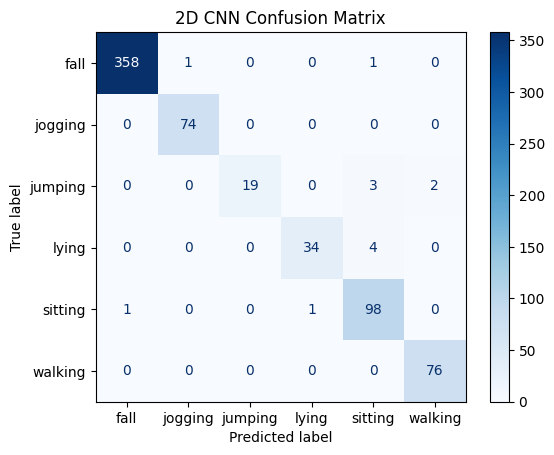

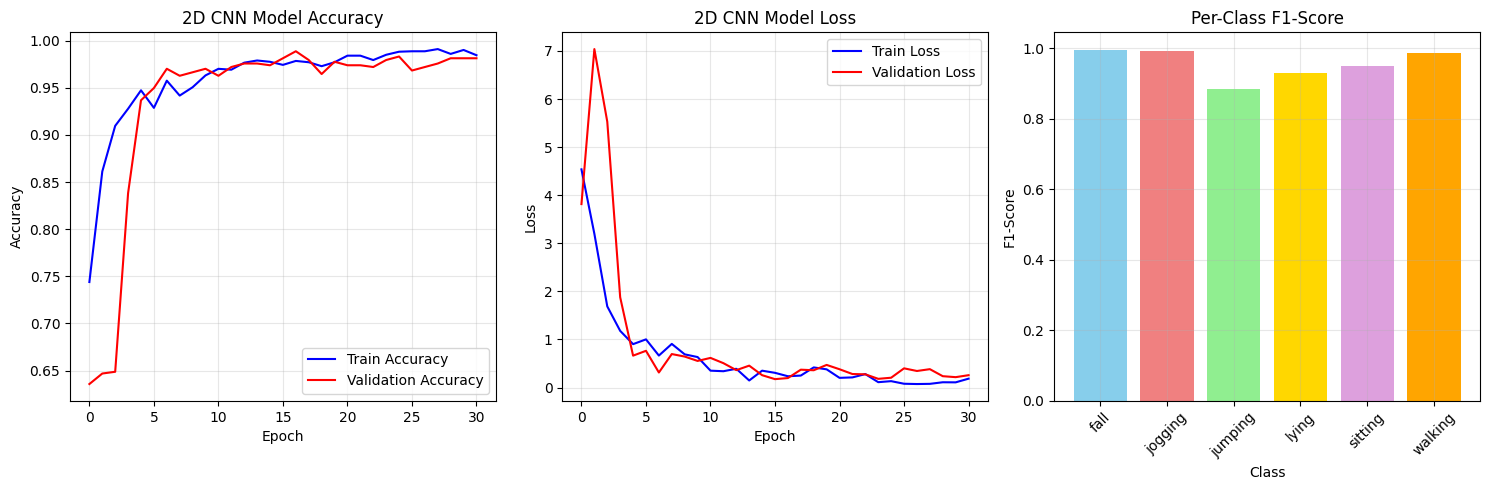

2D CNN model saved to models/cnn_2d_model.h5


In [38]:
# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title('2D CNN Confusion Matrix')
plt.show()

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history_2d.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history_2d.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('2D CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(history_2d.history['loss'], label='Train Loss', color='blue')
plt.plot(history_2d.history['val_loss'], label='Validation Loss', color='red')
plt.title('2D CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
# Plot per-class accuracy
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred, target_names=label_encoder.classes_, output_dict=True)
classes = list(report.keys())[:-3]  # Remove 'accuracy', 'macro avg', 'weighted avg'
accuracies = [report[cls]['f1-score'] for cls in classes]

plt.bar(classes, accuracies, color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum', 'orange'][:len(classes)])
plt.title('Per-Class F1-Score')
plt.xlabel('Class')
plt.ylabel('F1-Score')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save the model if needed
if should_save_models:
    suffix = '_gyro' if INCLUDE_GYROSCOPE else ''
    model_2d.save(f'{models_output_folder}cnn_2d_model{suffix}.h5')
    print(f"2D CNN model saved to {models_output_folder}cnn_2d_model{suffix}.h5")

In [ ]:
y_train

2305    sitting
2146       fall
487     walking
2084    jumping
1616       fall
         ...   
3061    jogging
2176    jogging
3311    jogging
387     sitting
2332       fall
Name: class, Length: 2686, dtype: object

In [ ]:



def save_model(model, filename):
    joblib.dump(model, filename)
    print(f"Model saved to {filename}")



svm = SVC(kernel='rbf', C=10, gamma='scale', probability=True, random_state=42)
svm.fit(X_train, y_train)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

nb = GaussianNB()
nb.fit(X_train, y_train)

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

# res = grid_search_hyperparameter_tuning(svm, X_train, y_train, X_test, y_test, 'SVM')





if should_save_models:
    suffix = '_gyro' if INCLUDE_GYROSCOPE else ''
    save_model(svm, models_output_folder + f'svm_model{suffix}.pkl')
    save_model(rf, models_output_folder + f'rf_model{suffix}.pkl')
    save_model(knn, models_output_folder + f'knn_model{suffix}.pkl')
    save_model(dt, models_output_folder + f'dt_model{suffix}.pkl')
    save_model(nb, models_output_folder + f'nb_model{suffix}.pkl')
    save_model(lr, models_output_folder + f'lr_model{suffix}.pkl')
    # save_model(scaler, models_output_folder + f'scaler{suffix}.pkl')


Model saved to models/svm_model.pkl
Model saved to models/rf_model.pkl
Model saved to models/knn_model.pkl
Model saved to models/dt_model.pkl
Model saved to models/nb_model.pkl
Model saved to models/lr_model.pkl


/Users/amir/Downloads/fall-detection-master/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: SVC
Classification Report:
              precision    recall  f1-score   support

        fall       0.95      0.95      0.95       360
     jogging       0.90      0.81      0.85        74
     jumping       0.79      0.92      0.85        24
       lying       0.93      0.74      0.82        38
     sitting       0.90      0.84      0.87       100
     walking       0.78      0.95      0.86        76

    accuracy                           0.91       672
   macro avg       0.87      0.87      0.87       672
weighted avg       0.91      0.91      0.91       672

Confusion Matrix:
Accuracy: 0.9062



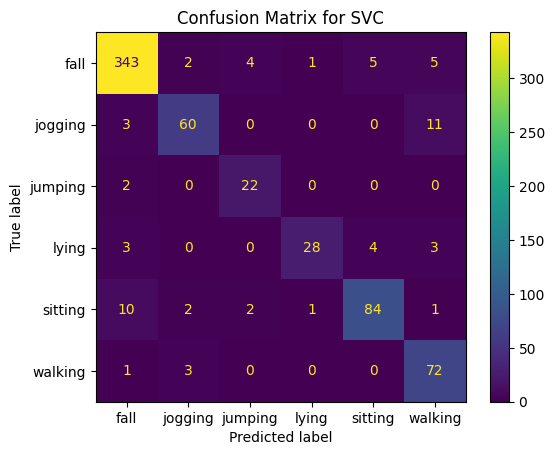

Model: RandomForestClassifier
Classification Report:
              precision    recall  f1-score   support

        fall       0.95      0.98      0.97       360
     jogging       0.96      0.92      0.94        74
     jumping       1.00      1.00      1.00        24
       lying       0.92      0.87      0.89        38
     sitting       0.94      0.89      0.91       100
     walking       0.94      0.95      0.94        76

    accuracy                           0.95       672
   macro avg       0.95      0.93      0.94       672
weighted avg       0.95      0.95      0.95       672

Confusion Matrix:
Accuracy: 0.9494



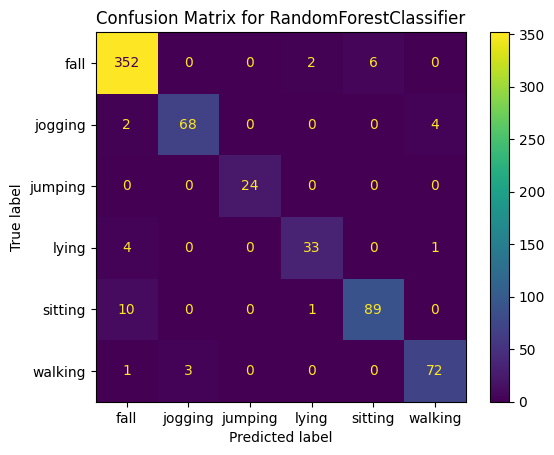

Model: KNeighborsClassifier
Classification Report:
              precision    recall  f1-score   support

        fall       0.94      0.89      0.91       360
     jogging       0.77      0.82      0.80        74
     jumping       0.73      1.00      0.84        24
       lying       0.91      0.76      0.83        38
     sitting       0.84      0.75      0.79       100
     walking       0.75      0.96      0.84        76

    accuracy                           0.87       672
   macro avg       0.82      0.86      0.84       672
weighted avg       0.88      0.87      0.87       672

Confusion Matrix:
Accuracy: 0.8676



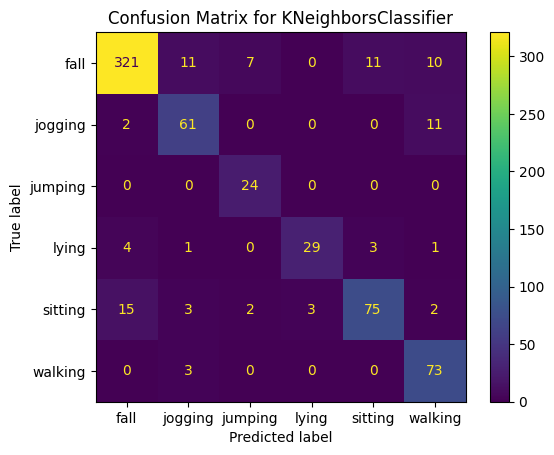

Model: DecisionTreeClassifier
Classification Report:
              precision    recall  f1-score   support

        fall       0.96      0.96      0.96       360
     jogging       0.84      0.86      0.85        74
     jumping       0.92      0.96      0.94        24
       lying       0.87      0.71      0.78        38
     sitting       0.85      0.87      0.86       100
     walking       0.87      0.89      0.88        76

    accuracy                           0.91       672
   macro avg       0.89      0.88      0.88       672
weighted avg       0.91      0.91      0.91       672

Confusion Matrix:
Accuracy: 0.9137



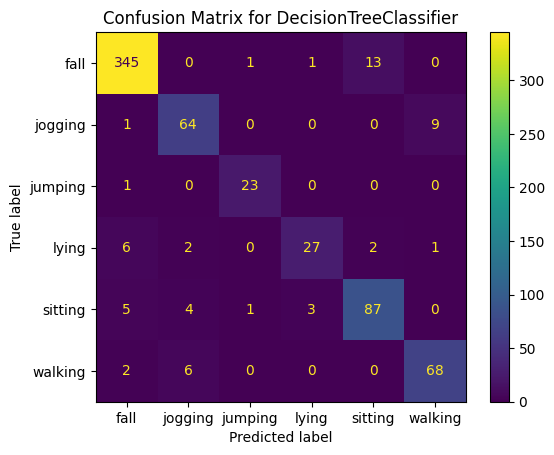

Model: GaussianNB
Classification Report:
              precision    recall  f1-score   support

        fall       0.89      0.78      0.83       360
     jogging       0.96      0.68      0.79        74
     jumping       0.96      1.00      0.98        24
       lying       0.40      0.92      0.56        38
     sitting       0.21      0.20      0.20       100
     walking       0.78      0.97      0.87        76

    accuracy                           0.72       672
   macro avg       0.70      0.76      0.70       672
weighted avg       0.76      0.72      0.73       672

Confusion Matrix:
Accuracy: 0.7202



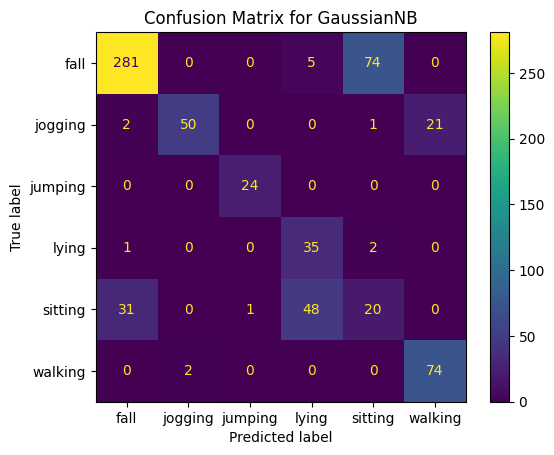

Model: LogisticRegression
Classification Report:
              precision    recall  f1-score   support

        fall       0.91      0.93      0.92       360
     jogging       0.88      0.82      0.85        74
     jumping       0.85      0.96      0.90        24
       lying       0.89      0.84      0.86        38
     sitting       0.72      0.66      0.69       100
     walking       0.85      0.92      0.89        76

    accuracy                           0.87       672
   macro avg       0.85      0.86      0.85       672
weighted avg       0.87      0.87      0.87       672

Confusion Matrix:
Accuracy: 0.8720



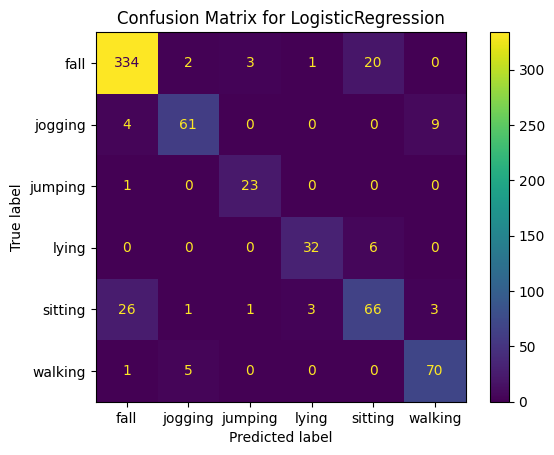

In [ ]:


def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"Model: {model.__class__.__name__}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='viridis')
    plt.title(f"Confusion Matrix for {model.__class__.__name__}")
    plt.show()

# Evaluate all models
evaluate_model(svm, X_test, y_test)
evaluate_model(rf, X_test, y_test)
evaluate_model(knn, X_test, y_test)
evaluate_model(dt, X_test, y_test)
evaluate_model(nb, X_test, y_test)
evaluate_model(lr, X_test, y_test)

      <!-- if activity_name == 'Walking':
                activity = 1
            elif activity_name == 'Jogging':
                activity = 2
            elif activity_name == 'GoDownstairs':
                activity = 5
            elif activity_name == 'GoUpstairs':
                activity = 6
            elif activity_name == 'LyingDown' and name_parts[5] == 'OnABed':
                activity = 7
            elif activity_name == 'Sitting' and name_parts[5] == 'GettingUpOnAChair':
                activity = 8
            
            
            
            elif activity_name == 'backwardFall':
                activity = 13
            elif activity_name == 'forwardFall':
                activity = 14
            elif activity_name == 'lateralFall':
                activity = 15
             -->

In [41]:
import os
import re

def uma_search_csv_files(directory, activities_of_interest=None):
    csv_files = []
    for current_folder, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.csv'):
                if activities_of_interest is not None:
                    for activity in activities_of_interest:
                        # Use regex to match exact activity number
                        pattern = rf"{activity}(?=Trial|_|\.csv)"
                        if re.search(pattern, file):
                            full_path = os.path.join(current_folder, file)
                            csv_files.append(full_path)
                            break
                else:
                    full_path = os.path.join(current_folder, file)
                    csv_files.append(full_path)
    return csv_files

In [ ]:
d = pd.read_csv('datasets/uma_test.csv')

,% TimeStamp; Sample No; X-Axis; Y-Axis; Z-Axis; Sensor Type; Sensor ID;
0,179;1;-0.1715855300426483;0.9238576889038086;-...
1,179;2;-0.1698771417140961;0.923247754573822;-0...
2,179;3;-0.1704870462417603;0.9211721420288086;-...
3,179;4;-0.173051193356514;0.921904981136322;-0....
4,179;5;-0.1734168231487274;0.9234920144081116;-...


In [ ]:
uma_files = uma_search_csv_files(directory=uma_dataset_folder, activities_of_interest=['Activity1','Activity2','Activity13', 'Activity14', 'Activity15'])

pd.read_csv(uma_files[0]).shape

(299, 8)

In [82]:
uma_files = uma_search_csv_files(directory=uma_dataset_folder, activities_of_interest=['Activity1','Activity2','Activity13', 'Activity14', 'Activity15'])

combined_df = pd.concat([pd.read_csv(file) for file in uma_files], ignore_index=True)

combined_df.rename(columns={
    'Accelerometer: x-axis (g)': 'acc_x',
    'Accelerometer: y-axis (g)': 'acc_y',
    'Accelerometer: z-axis (g)': 'acc_z',
    'Gyroscope: x-axis (rad/s)': 'gyro_x',
    'Gyroscope: y-axis (rad/s)': 'gyro_y',
    'Gyroscope: z-axis (rad/s)': 'gyro_z'
}, inplace=True)

# Display the shape of the combined dataframe
combined_df[700:710]


,TimeStamp,acc_x,acc_y,acc_z,Subject,Activity,Trial,Tag
700,7.337,0.133057,0.416016,0.917480,15,14,3,0
701,7.343,0.14209,0.410400,0.921387,15,14,3,0
702,7.348,0.14209,0.410400,0.921387,15,14,3,0
703,7.383,0.137695,0.414551,0.915039,15,14,3,0
704,7.432,0.132812,0.406738,0.918213,15,14,3,0
705,7.578,0.140869,0.412842,0.916260,15,14,3,0
706,7.581,0.140869,0.412842,0.916260,15,14,3,0
707,7.627,0.144775,0.407715,0.921875,15,14,3,0
708,7.630,0.140381,0.468262,0.917480,15,14,3,0
709,7.773,0.138184,0.465820,0.918457,15,14,3,0


In [78]:
combined_df

,TimeStamp,acc_x,acc_y,acc_z,Subject,Activity,Trial,Tag
0,0.220,0.930664,0.061279,0.353027,15,14,1,0
1,0.244,0.932373,0.127197,0.355957,15,14,1,0
2,0.260,0.932373,0.127197,0.355957,15,14,1,0
3,0.280,0.935791,0.060791,0.360352,15,14,1,0
4,0.293,0.935791,0.060791,0.360352,15,14,1,0
...,...,...,...,...,...,...,...,...
82692,14.872,-1.05127,-0.065918,0.307373,9,1,2,0
82693,14.892,-1.05127,-0.065918,0.307373,9,1,2,0
82694,14.913,-0.96582,0.075195,0.362549,9,1,2,0
82695,14.934,-0.96582,0.075195,0.362549,9,1,2,0


In [ ]:
# combined_df[['acc_x', 'acc_y', 'acc_z',]].values.reshape(-1, 3, 1).shape

(82697, 3, 1)

In [ ]:
# model_2d.predict(combined_df[['acc_x', 'acc_y', 'acc_z']].values.reshape(-1, 3, 1))

ValueError: Invalid dtype: object

In [83]:
grouped_data = []

# Sort by Subject, Activity, Trial, and TimeStamp to ensure proper ordering
combined_df_sorted = combined_df.sort_values(['Subject', 'Activity', 'Trial', 'TimeStamp']).reset_index(drop=True)

current_group = []
current_subject = None
current_activity = None
current_trial = None
group_id = 0

for idx, row in combined_df_sorted.iterrows():
    # Check if we're starting a new session (different subject/activity/trial)
    if (current_subject != row['Subject'] or 
        current_activity != row['Activity'] or 
        current_trial != row['Trial']):
        
        # Save the previous group if it exists
        if current_group:
            group_df = pd.DataFrame(current_group)

            if INCLUDE_GYROSCOPE:
                sensor_data = group_df[['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']]
            else:
                sensor_data = group_df[['acc_x', 'acc_y', 'acc_z']]

            timestamps = group_df['TimeStamp']
            
            group_row = {
                'subject': current_subject,
                'activity': f"D{current_activity}",
                'trial': current_trial,
                'group_id': group_id,
                'data': sensor_data,
                'timestamps': timestamps,
                'start_time': timestamps.iloc[0],
                'end_time': timestamps.iloc[-1],
                'duration': len(timestamps),
                'sampling_rate': len(timestamps) / (timestamps.iloc[-1] - timestamps.iloc[0]) if len(timestamps) > 1 else 0
            }
            grouped_data.append(group_row)
            group_id += 1
        
        # Start new group
        current_group = [row.to_dict()]
        current_subject = row['Subject']
        current_activity = row['Activity']
        current_trial = row['Trial']
    else:
        # Check if timestamp has reset/jumped backwards (indicating new data segment)
        if current_group:
            last_timestamp = current_group[-1]['TimeStamp']
            current_timestamp = row['TimeStamp']
            
            # If current timestamp is less than or equal to previous (reset occurred)
            if current_timestamp <= last_timestamp:
                # Save the current group
                group_df = pd.DataFrame(current_group)
                if INCLUDE_GYROSCOPE:
                    sensor_data = group_df[['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']]
                else:   
                    sensor_data = group_df[['acc_x', 'acc_y', 'acc_z']]
                timestamps = group_df['TimeStamp']
                
                group_row = {
                    'subject': current_subject,
                    'activity': f"D{current_activity}",
                    'trial': current_trial,
                    'group_id': group_id,
                    'data': sensor_data,
                    'timestamps': timestamps,
                    'start_time': timestamps.iloc[0],
                    'end_time': timestamps.iloc[-1],
                    'duration': len(timestamps),
                    'sampling_rate': len(timestamps) / (timestamps.iloc[-1] - timestamps.iloc[0]) if len(timestamps) > 1 else 0
                }
                grouped_data.append(group_row)
                group_id += 1
                
                # Start new group with current row
                current_group = [row.to_dict()]
            else:
                # Continue adding to current group
                current_group.append(row.to_dict())
        else:
            current_group.append(row.to_dict())

# Don't forget the last group
if current_group:
    group_df = pd.DataFrame(current_group)
    if INCLUDE_GYROSCOPE:
        sensor_data = group_df[['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']]
    else:
        sensor_data = group_df[['acc_x', 'acc_y', 'acc_z']]
    timestamps = group_df['TimeStamp']
    
    group_row = {
        'subject': current_subject,
        'activity': f"D{current_activity}",
        'trial': current_trial,
        'group_id': group_id,
        'data': sensor_data,
        'timestamps': timestamps,
        'start_time': timestamps.iloc[0],
        'end_time': timestamps.iloc[-1],
        'duration': len(timestamps),
        'sampling_rate': len(timestamps) / (timestamps.iloc[-1] - timestamps.iloc[0]) if len(timestamps) > 1 else 0
    }
    grouped_data.append(group_row)

# Convert to DataFrame
uma_dataset = pd.DataFrame(grouped_data)
print(f"Created {len(uma_dataset)} data segments based on timestamp breaks")
print(f"Segments per activity:")
activity_counts = uma_dataset['activity'].value_counts()
print(activity_counts)

# Show additional timestamp info
print(f"\nTimestamp information:")
print(f"Average segment duration: {uma_dataset['duration'].mean():.1f} samples")
print(f"Average sampling rate: {uma_dataset['sampling_rate'].mean():.1f} Hz")

uma_dataset

Created 281 data segments based on timestamp breaks
Segments per activity:
activity
D13    68
D14    67
D15    63
D1     55
D2     28
Name: count, dtype: int64

Timestamp information:
Average segment duration: 294.3 samples
Average sampling rate: 19.9 Hz


,subject,activity,trial,group_id,data,timestamps,start_time,end_time,duration,sampling_rate
0,1,D1,1,0,acc_x acc_y acc_z 0 -0.74023...,0 0.781 1 0.830 2 0.878 3 ...,0.781,14.980,285,20.071836
1,1,D1,2,1,acc_x acc_y acc_z 0 -0.76416...,0 0.349 1 0.360 2 0.368 3 ...,0.349,15.001,301,20.543271
2,1,D1,3,2,acc_x acc_y acc_z 0 -0.75732...,0 0.153 1 0.182 2 0.200 3 ...,0.153,14.956,300,20.266162
3,2,D1,1,3,acc_x acc_y acc_z 0 -0.95336...,0 0.114 1 0.144 2 0.162 3 ...,0.114,14.964,299,20.134680
4,2,D1,2,4,acc_x acc_y acc_z 0 -0.96289...,0 0.162 1 0.182 2 0.207 3 ...,0.162,14.950,299,20.219097
...,...,...,...,...,...,...,...,...,...,...
276,19,D15,2,276,acc_x acc_y acc_z 0 -1.02294...,0 0.257 1 0.327 2 0.336 3 ...,0.257,14.977,281,19.089674
277,19,D15,3,277,acc_x acc_y acc_z 0 -1.37255...,0 0.204 1 0.279 2 0.321 3 ...,0.204,14.967,293,19.846915
278,19,D15,4,278,acc_x acc_y acc_z 0 -0.92089...,0 0.193 1 0.293 2 0.390 3 ...,0.193,14.930,296,20.085499
279,19,D15,5,279,acc_x acc_y acc_z 0 -0.90795...,0 0.205 1 0.269 2 0.329 3 ...,0.205,14.990,299,20.223199


In [74]:
uma_dataset['data']

0               acc_x     acc_y     acc_z
0    -0.740...
1               acc_x     acc_y     acc_z
0    -0.764...
2               acc_x     acc_y     acc_z
0    -0.757...
3               acc_x     acc_y     acc_z
0    -0.953...
4               acc_x     acc_y     acc_z
0    -0.962...
                             ...                        
276             acc_x     acc_y     acc_z
0    -1.022...
277             acc_x     acc_y     acc_z
0    -1.372...
278             acc_x     acc_y     acc_z
0    -0.920...
279             acc_x     acc_y     acc_z
0    -0.907...
280             acc_x     acc_y     acc_z
0    -0.948...
Name: data, Length: 281, dtype: object

In [73]:
# uma_dataset['data'].values.reshape(-1, 3, 1)

data_cnn_uma = uma_dataset['data']
data_cnn_uma = data_cnn_uma.apply(lambda x: x.values.reshape(-1, 3, 1))  # Reshape for CNN input

data_cnn_uma[0].shape

(1800, 3, 1)

In [70]:
data_cnn_uma[2]

array([[[-0.75732422],
        [ 0.59887695],
        [ 0.22875977]],

       [[-0.75732422],
        [ 0.59887695],
        [ 0.22875977]],

       [[-0.75976562],
        [ 0.62915039],
        [ 0.22460938]],

       ...,

       [[-0.79077148],
        [ 0.80322266],
        [ 0.46118164]],

       [[-0.79077148],
        [ 0.80322266],
        [ 0.46118164]],

       [[-0.79077148],
        [ 0.80322266],
        [ 0.46118164]]])

In [ ]:
UMA_ACTIVITY_MAPPING = {
    'D1': 'walking',
    'D2': 'jogging',
    'D13': 'fall',
    'D14': 'fall',
    'D15': 'fall'
}


In [ ]:
data_cnn_uma

In [ ]:
uma_dataset['data'][0]

,acc_x,acc_y,acc_z
0,-0.740234,0.571289,0.249512
1,-0.842285,0.598145,0.297119
2,-0.833252,0.425781,0.332031
3,-0.721191,0.518311,0.116455
4,-0.741699,0.651611,0.380127
...,...,...,...
280,-0.878662,0.503418,0.118896
281,-0.760742,0.463623,0.170898
282,-0.702393,0.350342,0.258301
283,-0.600098,0.412842,0.168457


In [ ]:
import itertools
import numpy as np
import pandas as pd  # Don't forget this if not imported already

def extract_features(data, with_magnitude):
    """
    Extracts various features from the time and frequency domains from a given sample of activity. Also constructs
    features by combining the raw data.

    :param data: the data from the activity
    :param with_magnitude: calculate the magnitude of the sensors
    :return: list with all the features extracted from the activity
    """
    
    # Make a copy to avoid modifying original data
    data = data.copy()
    
    # Clean and ensure all data is numeric
    for col in data.columns:
        # Convert to string first, then replace any concatenated values
        data[col] = data[col].astype(str)
        # If values are concatenated, this won't work well, so let's handle it
        data[col] = pd.to_numeric(data[col], errors='coerce')
    
    # Fill any NaN values with 0
    data = data.fillna(0)
    
    # Check if we still have any non-numeric data
    if not data.select_dtypes(include=[np.number]).shape[1] == data.shape[1]:
        print("Warning: Non-numeric data detected, attempting to clean...")
        # Additional cleaning if needed
        for col in data.columns:
            if data[col].dtype == 'object':
                print(f"Column {col} contains non-numeric data")
                data[col] = 0  # Set problematic columns to 0
    
    # Calculates the acceleration and rotation magnitudes
    if with_magnitude:
        for i in range(0, data.shape[1], 3):
            if i + 2 < data.shape[1]:  # Ensure we have 3 columns
                # Select the 3-axis slice
                slice_ = data.iloc[:, i:i+3]
                
                # Compute magnitude
                magnitude = np.linalg.norm(slice_, axis=1)
                
                # Generate magnitude column name
                name = 'mag_' + data.columns[i][0:len(data.columns[i])-2]
                
                # Assign magnitude column
                data[name] = magnitude

    # Creates features vector name
    names = ['mean', 'var', 'std', 'median', 'max', 'min', 'ptp', 'centile25', 'centile75']
    columns = list('_'.join(n) for n in itertools.product(names, data.columns.tolist()))

    # Time domain features
    features = np.mean(data, axis=0)
    features = np.hstack((features, np.var(data, axis=0)))
    features = np.hstack((features, np.std(data, axis=0)))
    features = np.hstack((features, np.median(data, axis=0)))
    features = np.hstack((features, np.max(data, axis=0)))
    features = np.hstack((features, np.min(data, axis=0)))
    features = np.hstack((features, np.ptp(np.asarray(data), axis=0)))
    features = np.hstack((features, np.percentile(data, 25, axis=0)))
    features = np.hstack((features, np.percentile(data, 75, axis=0)))

    # Creates a DataFrame
    features = pd.DataFrame([features], columns=columns)
    return features

# Extract features from uma_dataset
print("Processing UMA dataset...")
feature_list = []
labels = []
subjects = []
activity_codes = []

for i in uma_dataset.index:
    # Get data from each row
    data = uma_dataset['data'][i]
    
    # Extract features
    features_uma = extract_features(data, True)
    
    # Store results
    feature_list.append(features_uma)
    subjects.append(uma_dataset['subject'][i])
    activity_codes.append(uma_dataset['activity'][i])

# Combine into final dataset
uma_prepared_dataset = pd.concat(feature_list, ignore_index=True)
uma_prepared_dataset['subject'] = subjects
uma_prepared_dataset['activity_code'] = activity_codes

print(f"UMA dataset shape: {uma_prepared_dataset.shape}")
print("\nActivity code distribution:")
print(uma_prepared_dataset['activity_code'].value_counts())

uma_prepared_dataset

Processing UMA dataset...
UMA dataset shape: (281, 38)

Activity code distribution:
activity_code
D13    68
D14    67
D15    63
D1     55
D2     28
Name: count, dtype: int64


,mean_acc_x,mean_acc_y,mean_acc_z,mean_mag_acc,var_acc_x,var_acc_y,var_acc_z,var_mag_acc,std_acc_x,std_acc_y,...,centile25_acc_x,centile25_acc_y,centile25_acc_z,centile25_mag_acc,centile75_acc_x,centile75_acc_y,centile75_acc_z,centile75_mag_acc,subject,activity_code
0,-0.748402,0.572373,0.265424,0.989671,0.010993,0.009095,0.012568,0.011373,0.104850,0.095367,...,-0.812744,0.504150,0.204346,0.918750,-0.674072,0.633789,0.338379,1.046824,1,D1
1,-0.648921,0.610286,0.361364,0.999880,0.036785,0.015908,0.038167,0.015232,0.191793,0.126126,...,-0.765381,0.549805,0.231689,0.928399,-0.610352,0.674561,0.394531,1.055870,1,D1
2,-0.642502,0.666831,0.311903,0.985959,0.010756,0.009004,0.008315,0.010715,0.103709,0.094890,...,-0.731873,0.600159,0.235718,0.917690,-0.567505,0.749023,0.382202,1.034498,1,D1
3,-1.043552,-0.281974,0.108950,1.114262,0.077249,0.024974,0.031381,0.072405,0.277937,0.158032,...,-1.207764,-0.375854,0.008301,0.953660,-0.876465,-0.184448,0.216675,1.261053,2,D1
4,-0.877046,-0.428425,0.229331,1.070247,0.087546,0.056010,0.087403,0.090880,0.295881,0.236664,...,-1.005859,-0.545898,0.068726,0.920448,-0.725220,-0.288696,0.365967,1.128142,2,D1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,-0.198070,0.358674,0.618709,1.052136,0.152059,0.229037,0.209130,0.033916,0.389947,0.478578,...,-0.272461,-0.112061,0.579102,0.971959,-0.060791,0.700684,0.864258,1.090969,19,D15
277,-0.144246,0.619491,-0.081711,1.126797,0.184675,1.139300,0.496442,0.961999,0.429738,1.067380,...,-0.020020,0.783691,-0.081299,0.935022,-0.008301,0.937256,0.035400,1.004671,19,D15
278,-0.619123,-0.596731,0.389268,1.068791,0.053604,0.128418,0.136904,0.067544,0.231526,0.358355,...,-0.708740,-0.774841,0.178711,0.986254,-0.533203,-0.464844,0.564209,1.084290,19,D15
279,-0.144801,0.470989,-0.601326,0.959936,0.084430,0.114638,0.153182,0.035164,0.290569,0.338582,...,-0.089111,0.479614,-0.769409,0.905493,-0.045898,0.631104,-0.670776,0.959350,19,D15


In [ ]:
UMA_ACTIVITY_MAPPING = {
    'D1': 'walking',
    'D2': 'jogging',
    'D13': 'fall',
    'D14': 'fall',
    'D15': 'fall'
}

activity_codes = uma_prepared_dataset['activity_code'] 
y_labels = activity_codes.map(UMA_ACTIVITY_MAPPING)


X_uma = uma_prepared_dataset.drop(columns=['activity_code', 'subject'])
X_uma

,mean_acc_x,mean_acc_y,mean_acc_z,mean_mag_acc,var_acc_x,var_acc_y,var_acc_z,var_mag_acc,std_acc_x,std_acc_y,...,ptp_acc_z,ptp_mag_acc,centile25_acc_x,centile25_acc_y,centile25_acc_z,centile25_mag_acc,centile75_acc_x,centile75_acc_y,centile75_acc_z,centile75_mag_acc
0,-0.748402,0.572373,0.265424,0.989671,0.010993,0.009095,0.012568,0.011373,0.104850,0.095367,...,0.669189,0.620804,-0.812744,0.504150,0.204346,0.918750,-0.674072,0.633789,0.338379,1.046824
1,-0.648921,0.610286,0.361364,0.999880,0.036785,0.015908,0.038167,0.015232,0.191793,0.126126,...,1.385986,1.390414,-0.765381,0.549805,0.231689,0.928399,-0.610352,0.674561,0.394531,1.055870
2,-0.642502,0.666831,0.311903,0.985959,0.010756,0.009004,0.008315,0.010715,0.103709,0.094890,...,0.555420,0.583319,-0.731873,0.600159,0.235718,0.917690,-0.567505,0.749023,0.382202,1.034498
3,-1.043552,-0.281974,0.108950,1.114262,0.077249,0.024974,0.031381,0.072405,0.277937,0.158032,...,1.173096,1.716752,-1.207764,-0.375854,0.008301,0.953660,-0.876465,-0.184448,0.216675,1.261053
4,-0.877046,-0.428425,0.229331,1.070247,0.087546,0.056010,0.087403,0.090880,0.295881,0.236664,...,3.214844,2.868545,-1.005859,-0.545898,0.068726,0.920448,-0.725220,-0.288696,0.365967,1.128142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,-0.198070,0.358674,0.618709,1.052136,0.152059,0.229037,0.209130,0.033916,0.389947,0.478578,...,3.726074,2.061288,-0.272461,-0.112061,0.579102,0.971959,-0.060791,0.700684,0.864258,1.090969
277,-0.144246,0.619491,-0.081711,1.126797,0.184675,1.139300,0.496442,0.961999,0.429738,1.067380,...,7.896973,9.651395,-0.020020,0.783691,-0.081299,0.935022,-0.008301,0.937256,0.035400,1.004671
278,-0.619123,-0.596731,0.389268,1.068791,0.053604,0.128418,0.136904,0.067544,0.231526,0.358355,...,3.515381,3.522952,-0.708740,-0.774841,0.178711,0.986254,-0.533203,-0.464844,0.564209,1.084290
279,-0.144801,0.470989,-0.601326,0.959936,0.084430,0.114638,0.153182,0.035164,0.290569,0.338582,...,3.291016,2.171418,-0.089111,0.479614,-0.769409,0.905493,-0.045898,0.631104,-0.670776,0.959350


In [ ]:
# Prepare UMA data for model evaluation
# Reshape for CNN input (adding time dimension of 1)
X_uma_cnn = X_uma.values.reshape(X_uma.shape[0], X_uma.shape[1], 1)

# Use the same label encoder to ensure consistent mapping
y_uma_encoded = label_encoder.transform(y_labels)
y_uma_categorical = to_categorical(y_uma_encoded, num_classes=n_classes)

# Evaluate CNN model on UMA dataset
loss_uma, accuracy_uma = model.evaluate(X_uma_cnn, y_uma_categorical)
print(f"UMA dataset evaluation:")
print(f"Loss: {loss_uma:.4f}")
print(f"Accuracy: {accuracy_uma:.4f}")

# Get predictions
y_uma_pred_prob = model.predict(X_uma_cnn)
y_uma_pred = np.argmax(y_uma_pred_prob, axis=1)
y_uma_true = np.argmax(y_uma_categorical, axis=1)



9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4308 - loss: 4.8561
UMA dataset evaluation:
Loss: 4.3757
Accuracy: 0.4377
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [ ]:
predicted_uma_fall = svm.predict(X_uma)
confusion_matrix(y_labels, predicted_uma_fall)

array([[86, 14, 23, 59, 16],
       [ 8,  1, 14,  4,  1],
       [ 0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0],
       [ 1,  0,  0, 54,  0]])

In [ ]:
predicted_uma_fall_dt = dt.predict(X_uma)
confusion_matrix(y_labels, predicted_uma_fall)

array([[86, 14, 23, 59, 16],
       [ 8,  1, 14,  4,  1],
       [ 0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0],
       [ 1,  0,  0, 54,  0]])

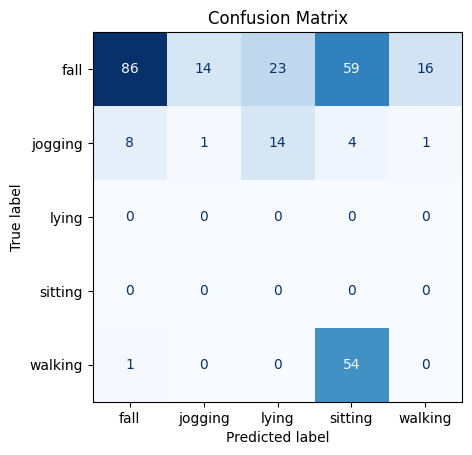

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_labels, predicted_uma_fall)

# Ensure the labels match the unique classes in the confusion matrix
unique_classes = np.unique(np.concatenate((y_labels, predicted_uma_fall)))

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_classes)
disp.plot(cmap='Blues', colorbar=False)
plt.title("Confusion Matrix")
plt.show()

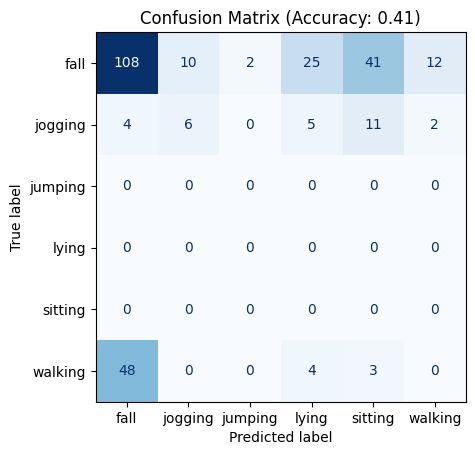

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score

# Generate confusion matrix
cm = confusion_matrix(y_labels, predicted_uma_fall_dt)

# Calculate accuracy
accuracy = accuracy_score(y_labels, predicted_uma_fall_dt)

# Ensure the labels match the unique classes in the confusion matrix
unique_classes = np.unique(np.concatenate((y_labels, predicted_uma_fall_dt)))

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_classes)
disp.plot(cmap='Blues', colorbar=False)
plt.title(f"Confusion Matrix (Accuracy: {accuracy:.2f})")
plt.show()

In [ ]:
y_labels_unq = np.unique(y_labels)
y_labels_unq

array(['fall', 'jogging', 'walking'], dtype=object)

In [ ]:
unique_labels = np.unique(predicted_uma_fall)
unique_labels

array(['fall', 'jogging', 'lying', 'sitting', 'walking'], dtype=object)